# Auswertung 27.05.2025
Auswertung mit vergleich von TBBB TCBC und LNO

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit

import glob
import re

def dat2array(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace(',', '.').replace('\t', ';').replace('\n', '')
            if i >= 39:  # Skip header lines
                data.append(line.split(';'))

    freqs = [float(row[0]) for row in data]
    intensities = [float(row[1]) for row in data]
    return freqs, intensities
    
def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def gaussian(x, a, mean, sigma):
    return a * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

In [49]:
def create_shg_plot(middle_value, difference, filepath, suptitle, filename_prefix):
    x_range = (middle_value - difference, middle_value + difference)
    file_list = glob.glob(filepath)

    sorted_files = []
    for f in file_list:
        meas_no, temperature = extract_info(f)
        if meas_no is not None:
            sorted_files.append((f, meas_no, temperature))

    sorted_files.sort(key=lambda x: x[1])
    temperatures = [x[2] for x in sorted_files]
    norm = plt.Normalize(min(temperatures), max(temperatures))
    colors = cm.plasma(norm(temperatures))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    peak_list = []
    temps_for_line = []
    peaks_for_line = []

    for idx, (f, meas_no, temperature) in enumerate(sorted_files):
        freqs, intensities = dat2array(f)
        intensities = [val / 131942273.14285715 for val in intensities]
        filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
        filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])

        # ax0.plot(filtered_freqs, filtered_intensities, color='lightgray')  # Plot in Hellgrau
        # ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])  # Diese Zeile auskommentieren, um Originalkurve auszublenden
        
        if filtered_intensities:
            popt, _ = curve_fit(gaussian, filtered_freqs, filtered_intensities, p0=[max(filtered_intensities), np.mean(filtered_freqs), 10])    # Gaussian fit
            fitted_curve = gaussian(np.array(filtered_freqs), *popt)    # Gaussian fit
            ax0.plot(filtered_freqs, fitted_curve, color=colors[idx])   # Gaussian fit
            peak = max(filtered_intensities)
            peak_list.append(peak)
            ax1.scatter(temperature, peak, color=colors[idx])
            temps_for_line.append(temperature)
            peaks_for_line.append(peak)

    sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
    cbar.set_label('Temperature in K')
    cbar.set_ticks([min(temperatures), max(temperatures)])
    cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

    ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)
    if temps_for_line and peaks_for_line:
        ax1.annotate('Start', xy=(temps_for_line[0], peaks_for_line[0]), xytext=(5, 5),
                     textcoords='offset points', fontsize=10, color='green', fontweight='bold')
        ax1.annotate('End', xy=(temps_for_line[-1], peaks_for_line[-1]), xytext=(5, 5),
                     textcoords='offset points', fontsize=10, color='red', fontweight='bold')

    ax0.set_xlim(x_range)
    ax0.set_xlabel('Wavelength in nm')
    ax0.set_ylabel('Intensity in arb.u.')
    ax1.set_xlabel('Temperature in K')
    ax1.set_ylabel('Max Intensity in a.u.')

    fig.suptitle(suptitle, fontsize=16)
    fig.text(0.5, 0.914, "Measurement parameters: Power: 333µW, Slit width=210µm", ha="center")
    plt.show()

    fig.savefig(f'./{filename_prefix}.png', dpi=600, bbox_inches='tight')
    fig.savefig(f'./{filename_prefix}.pdf', dpi=600, bbox_inches='tight')
    # print("The maximum intensity across all temperatures is:", max(peak_list))

## TBBB

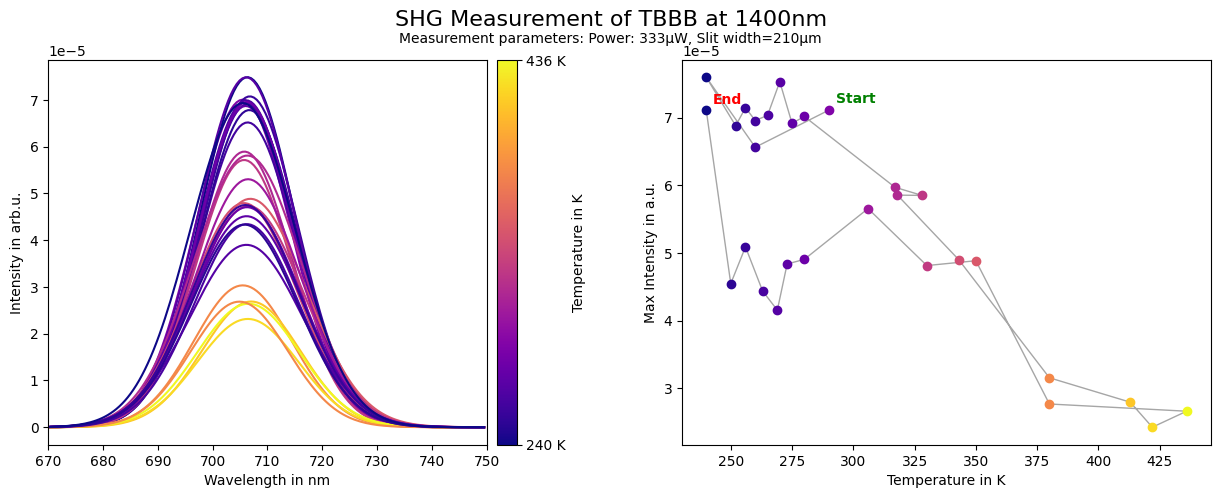

In [50]:
create_shg_plot(
    middle_value=710,
    difference=40,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of TBBB at 1400nm',
    filename_prefix='TBBB_SHG'
)

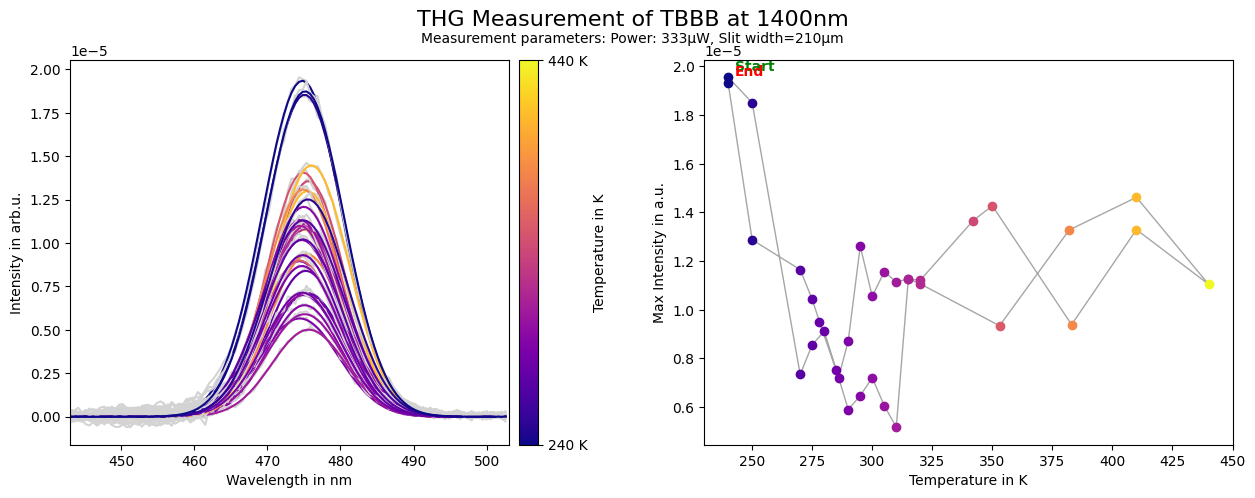

In [48]:
create_shg_plot(
    middle_value=473,
    difference=30,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of TBBB at 1400nm',
    filename_prefix='TBBB_THG'
)

## TCBC

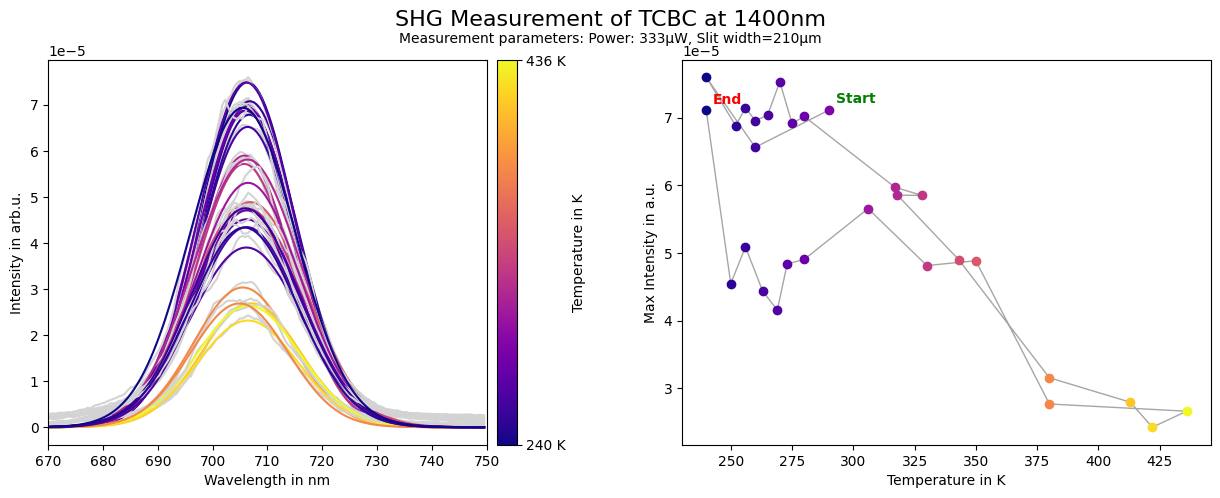

In [47]:
create_shg_plot(
    middle_value=710,
    difference=40,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Measurement of TCBC at 1400nm',
    filename_prefix='TCBC_SHG'
)

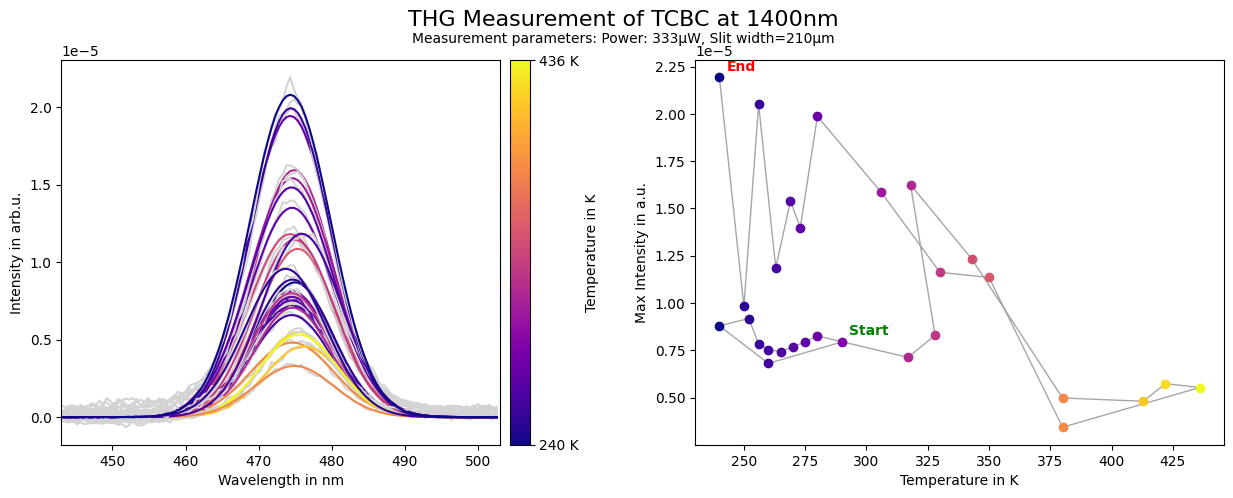

In [46]:
create_shg_plot(
    middle_value=473,
    difference=30,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of TCBC at 1400nm',
    filename_prefix='TCBC_THG'
)

## LNO

#### Vergleichsmessung

NameError: name 'filtered_freqs_ohne' is not defined

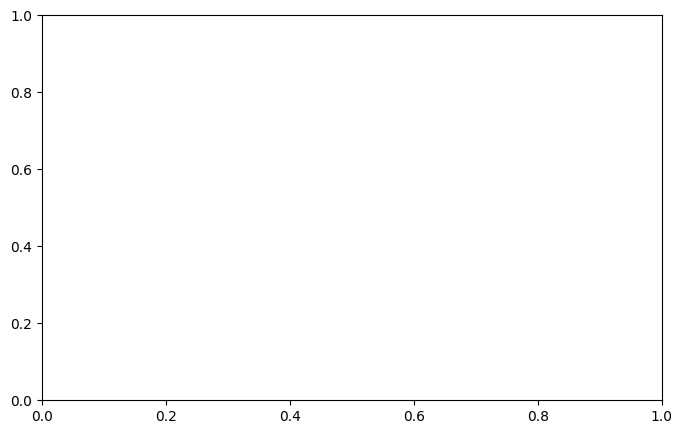

In [36]:
fig, ax0 = plt.subplots(figsize=(8, 5))
ax0.plot(filtered_freqs_ohne, filtered_intensities_ohne, label='ohne ND2.0')
ax0.plot(filtered_freqs_mit, filtered_intensities_mit, label='mit ND2.0')
ax0.set_title('Vergleich: ohne ND2.0 vs. mit ND2.0')
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')
ax0.set_yscale('log')
ax0.legend()

peak_ohne = max(filtered_intensities_ohne)
peak_mit = max(filtered_intensities_mit)
peak_ohne_x = filtered_freqs_ohne[filtered_intensities_ohne.index(peak_ohne)]
peak_mit_x = filtered_freqs_mit[filtered_intensities_mit.index(peak_mit)]

ax0.annotate(f'Peak: {peak_ohne:.0f}', xy=(peak_ohne_x, peak_ohne), xytext=(peak_ohne_x+2, peak_ohne*1.2),
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue', fontsize=10)
ax0.annotate(f'Peak: {peak_mit:.0f}', xy=(peak_mit_x, peak_mit), xytext=(peak_mit_x+2, peak_mit*1.2),
             arrowprops=dict(arrowstyle='->', color='orange'), color='orange', fontsize=10)

plt.show()

# Berechne den Skalierungsfaktor, um die Messung mit ND2.0 auf die ohne ND2.0 zu bringen
skalierungsfaktor = peak_ohne / peak_mit
print(f"Skalierungsfaktor (ohne ND2.0 / mit ND2.0): {skalierungsfaktor:.2f}")

### Messung

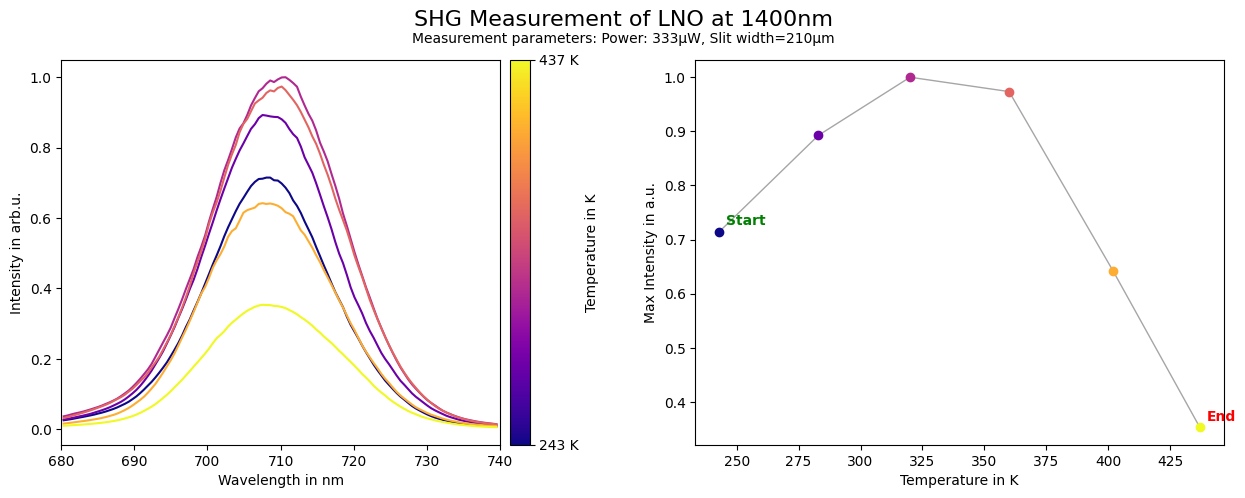

The maximum intensity across all temperatures is: 1.0


In [ ]:
# Define the range for the x-axis
middle_value = 710
difference = 30
x_range = (middle_value - difference, middle_value + difference)

file_list = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc')

sorted_files = []
for f in file_list:
    meas_no, temperature = extract_info(f)
    if meas_no is not None:
        sorted_files.append((f, meas_no, temperature))


sorted_files.sort(key=lambda x: x[1])  # Nach Messnummer sortieren

# Erzeuge das Farbfeld anhand der Temperaturwerte
temperatures = [x[2] for x in sorted_files]
norm = plt.Normalize(min(temperatures), max(temperatures))
colors = cm.plasma(norm(temperatures))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
peak_list = []

# Listen für Verbindungslinie im rechten Plot
temps_for_line = []
peaks_for_line = []

for idx, (f, meas_no, temperature) in enumerate(sorted_files):
    freqs, intensities = dat2array(f)
    intensities = [val * 32.88 *(10/7) for val in intensities]  # Reskalierung um Faktor 32.88 für ND2 und 0,07s ausgleichen
    intensities = [val / 131942273.14285715 for val in intensities]  # Normalisierung
    filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
    filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])
    
    ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
    if filtered_intensities:
        peak = max(filtered_intensities)
        peak_list.append(peak)
        ax1.scatter(temperature, peak, color=colors[idx])
        temps_for_line.append(temperature)
        peaks_for_line.append(peak)

# Colorbar für Temperatur
sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
cbar.set_label('Temperature in K')
cbar.set_ticks([min(temperatures), max(temperatures)])
cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

# Punkte im rechten Plot verbinden (Messreihenfolge)
ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)

# Start- und Endpunkt beschriften
if temps_for_line and peaks_for_line:
    ax1.annotate('Start', xy=(temps_for_line[0], peaks_for_line[0]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='green', fontweight='bold')
    ax1.annotate('End', xy=(temps_for_line[-1], peaks_for_line[-1]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', fontweight='bold')

ax0.set_xlim(x_range)
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')

ax1.set_xlabel('Temperature in K')
ax1.set_ylabel('Max Intensity in a.u.')

fig.suptitle('SHG Measurement of LNO at 1400nm', fontsize=16)
fig.text(0.5, 0.914, "Measurement parameters: Power: 333µW, Slit width=210µm", ha="center")
plt.show()
fig.savefig('./LNO_SHG.png', dpi=600, bbox_inches='tight')
fig.savefig('./LNO_SHG.pdf', dpi=600, bbox_inches='tight')
# Print the maximum value from the peak_list
print("The maximum intensity across all temperatures is:", max(peak_list))

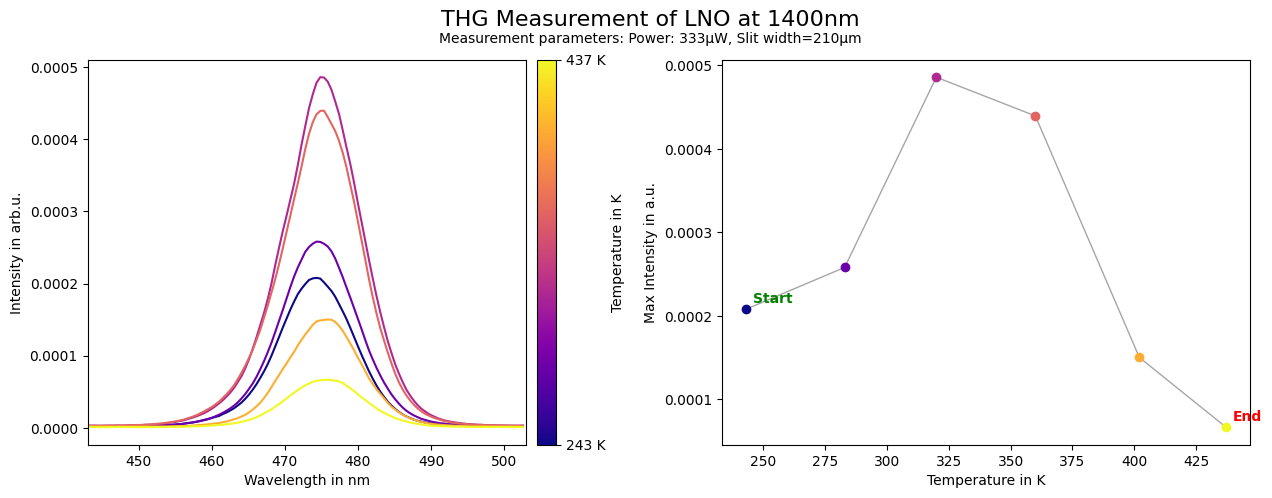

The maximum intensity across all temperatures is: 0.00048588673268185707


In [ ]:
create_shg_plot(
    middle_value=473,
    difference=30,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Measurement of LNO at 1400nm',
    filename_prefix='LNO_THG'
)